In [1]:
import glob
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [2]:
#@title NN parameters
IMG_SIZE = 224 #@param {type:"integer"}
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

SPLIT_WEIGHTS = (8, 1, 1)
BATCH_SIZE = 32 #@param {type:"integer"}
SHUFFLE_BUFFER_SIZE = 1000

drive_path = '/content/drive/MyDrive' #@param {type:"string"}

In [9]:
#@title Download and unpack dataset

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Download and unpack dataset
!mkdir dataset
!unzip drive/MyDrive/image_photo_classifier/dataset/photos.zip -d dataset
!unzip drive/MyDrive/image_photo_classifier/dataset/other.zip -d dataset
!unzip drive/MyDrive/image_photo_classifier/dataset/screenshots.zip -d dataset

clear_output()

In [10]:
#@title Load images data
    
def get_files_in_folder(path: str) -> list:
    return list(glob.glob(f'{path}/*.jpg'))

def read_image(image_path) -> list:
    target_size = (IMG_SIZE, IMG_SIZE)
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode = "rgb", target_size=target_size)
    x = tf.keras.preprocessing.image.img_to_array(img)
    return x

# create dataset
x_photos = [read_image(x) for x in get_files_in_folder('dataset/photos')]
x_screens = [read_image(x) for x in get_files_in_folder('dataset/screenshots')]
x_others = [read_image(x) for x in get_files_in_folder('dataset/other')]

x_train = []
y_train = []
[(x_train.append(f), y_train.append(0)) for f in x_photos] # photo as photo
[(x_train.append(f), y_train.append(1)) for f in x_screens] # screen as image
[(x_train.append(f), y_train.append(1)) for f in x_others] # other images as image

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

print('Done')
print(f'Image shapes: {x_train.shape}')

Done
Image shapes: (2298, 224, 224, 3)


In [11]:
#@title Create TensorFlow compatible dataset and free memory

train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.20)
train_y = train_y.astype(np.float32)
test_y = test_y.astype(np.float32)

#free memory
del x_train, y_train

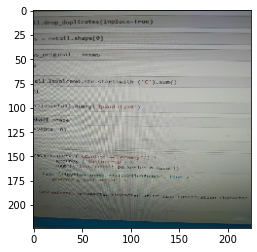

In [12]:
#@title Show random image from dataset

index = np.random.choice(len(test_x))
img = test_x[index]
img = img.reshape(IMG_SHAPE)

plt.imshow((img.reshape(IMG_SHAPE)).astype(np.uint8), vmin=0, vmax=255)
plt.show()

In [22]:
#@title MobileNetV2 model

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False)

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_2 (Dropout)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 62721     
                                                                 
Total params: 2,320,705
Trainable params: 2,286,593
Non-trainable params: 34,112
_________________________________________________________________


In [23]:
#@title Train model
epochs = 20 #@param {type:"slider", min:1, max:55, step:1}
score = model.fit(train_x, train_y, batch_size=32, epochs=epochs, validation_data = (test_x, test_y))

Epoch 1/20
58/58 [==============================] - 29s 399ms/step - loss: 0.2935 - accuracy: 0.8770 - val_loss: 0.8676 - val_accuracy: 0.7130
Epoch 2/20
58/58 [==============================] - 22s 378ms/step - loss: 0.0339 - accuracy: 0.9886 - val_loss: 1.3497 - val_accuracy: 0.6957
Epoch 3/20
58/58 [==============================] - 22s 376ms/step - loss: 0.0101 - accuracy: 0.9984 - val_loss: 1.3760 - val_accuracy: 0.7022
Epoch 4/20
58/58 [==============================] - 22s 378ms/step - loss: 0.0078 - accuracy: 0.9989 - val_loss: 1.4003 - val_accuracy: 0.7109
Epoch 5/20
58/58 [==============================] - 22s 377ms/step - loss: 0.0095 - accuracy: 0.9978 - val_loss: 1.0809 - val_accuracy: 0.7609
Epoch 6/20
58/58 [==============================] - 22s 377ms/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.8784 - val_accuracy: 0.8000
Epoch 7/20
58/58 [==============================] - 22s 376ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.8595 - val_accuracy: 0.8174

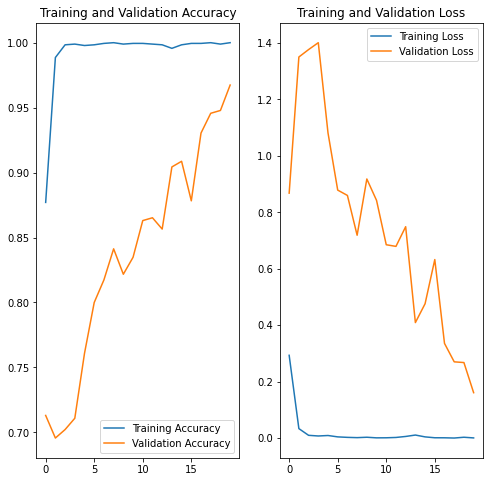

In [24]:
#@title Train history

acc = score.history['accuracy']
val_acc = score.history['val_accuracy']

loss = score.history['loss']
val_loss = score.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

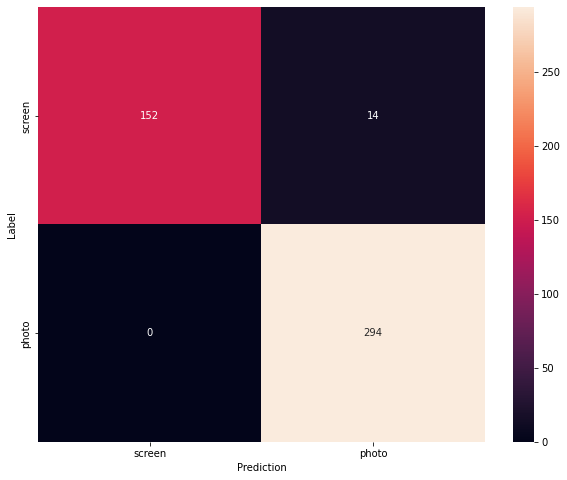

In [27]:
#@title Confusion matrix
import seaborn as sns

label_names = ['screen', 'photo']

def predict_class_label_number(dataset):
  results = []

  for img in dataset:
      img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
      result = model.predict(img)
      res = min(max(result[0][0], 0), 1)
      results.append(res)

  return results

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

confusion_mtx = tf.math.confusion_matrix(test_y, predict_class_label_number(test_x), num_classes=len(label_names))

show_confusion_matrix(confusion_mtx, label_names)

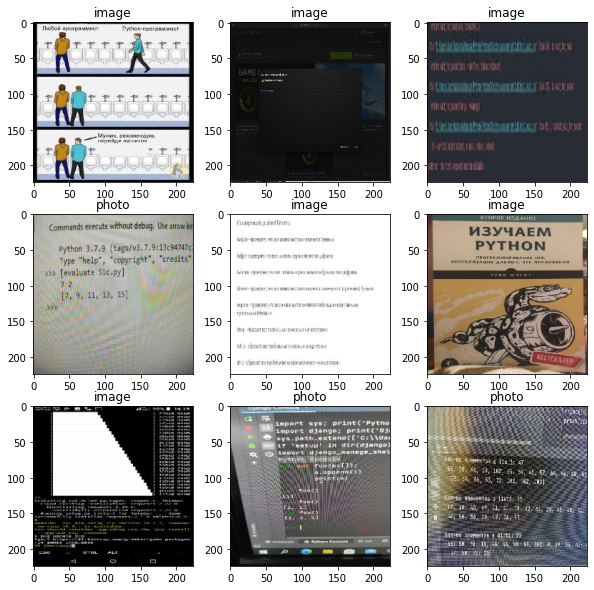

In [28]:
#@title Make 9 predictions
indexes = np.random.choice(len(test_x), 29)

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = test_x[indexes[i]]
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 3)
    result = model.predict(img)
    class_label = "image" if result[0][0] > 0 else "photo"
    str_result = f"{class_label}"
    plt.title(str_result)
    plt.imshow((img.reshape(IMG_SIZE, IMG_SIZE, 3)).astype(np.uint8))

In [25]:
#@title Convert model

model_name = 'mobilenet2_image_photo_predictor_rgb_v1.0_224' #@param {type:"string"}

save_model = True #@param {type:"boolean"}
if save_model:
    print(f'Saving model to {drive_path}/{model_name}.h5')
    model.save(f'{drive_path}/{model_name}.h5')
    print(f'Saved')


save_tfjs_model = True  #@param {type:"boolean"}
if save_tfjs_model:
    !pip install tensorflowjs
    import tensorflowjs as tfjs
    clear_output()
    tfjs.converters.save_keras_model(model, f"{drive_path}/{model_name}")


save_tflite_model = True #@param {type:"boolean"}
if save_tflite_model:
    print(f'Saving model to {drive_path}/{model_name}.tflite')
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open(f'{drive_path}/{model_name}.tflite', 'wb') as f:
        f.write(tflite_model)
        print(f'Saved')


save_tflite_quant_model = True #@param {type:"boolean"}
if save_tflite_quant_model:
    print(f'Saving quant model to {drive_path}/{model_name}_quant.tflite')
    # A generator that provides a representative dataset
    def representative_data_gen():
        for image in test_x[:100]:
          im = image.reshape(1, IMG_SHAPE[0], IMG_SHAPE[0], IMG_SHAPE[2]).astype(np.float32)
          yield [im]

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # This enables quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # This sets the representative dataset for quantization
    converter.representative_dataset = representative_data_gen
    # This ensures that if any ops can't be quantized, the converter throws an error
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    # For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
    converter.target_spec.supported_types = [tf.int8]
    # These set the input and output tensors to uint8 (added in r2.3)
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    tflite_model = converter.convert()


    with open(f'{drive_path}/{model_name}_quant.tflite', 'wb') as f:
        f.write(tflite_model)
        print(f'Saved')

Saving model to /content/drive/MyDrive/mobilenet2_image_photo_predictor_rgb_v1.0_224.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved
Saving model to /content/drive/MyDrive/mobilenet2_image_photo_predictor_rgb_v1.0_224.tflite


INFO:tensorflow:Assets written to: /tmp/tmpnj1s439v/assets


INFO:tensorflow:Assets written to: /tmp/tmpnj1s439v/assets


Saved
Saving quant model to /content/drive/MyDrive/mobilenet2_image_photo_predictor_rgb_v1.0_224_quant.tflite


INFO:tensorflow:Assets written to: /tmp/tmp8sedffzf/assets


INFO:tensorflow:Assets written to: /tmp/tmp8sedffzf/assets


Saved
